In [1]:
import os
import pickle
import time
import numpy as np
import json
import matplotlib.pyplot as plt
from types import SimpleNamespace

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists

In [2]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.ImplicitLG
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "data_dump_" + str(SCALE_PARAM) + ".dat")

with open("../config.json", "r") as infile:
    cfg_dict = json.load(infile)  # Config(SCALE_PARAM)
    cfg = SimpleNamespace(**cfg_dict)
    cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX = compute_pylon_dists(
        cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX, cfg.RASTER, SCALE_PARAM
    )

graph type: <class 'power_planner.graphs.implicit_lg.ImplicitLG'>
defined pylon distances in raster: 3.0 5.0


In [3]:
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data

In [10]:
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=cfg.ANGLE_WEIGHT
)
graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
# add vertices
graph.add_nodes()

# START PIPELINE
tic = time.time()
corridor = np.ones(instance_corr.shape) * 0.5  # start with all
output_paths = []
plot_surfaces = []
time_infos = []

for (factor, dist) in PIPELINE:
    print("----------- PIPELINE", factor, dist, "---------------")
    graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=factor)
    print("1) set cost rest")

cost weights [0.09090909 0.25974026 0.32467532 0.12987013 0.19480519]
instance shape (146, 260)
memory taken (dists shape): 1062880
----------- PIPELINE 1 0 ---------------
1) set cost rest


In [ ]:
def add_edges_new(self):
    tic = time.time()

    # precompute angles
    angles_all = self._precompute_angles()

    for _ in range(self.n_iters):
        # iterate over edges
        for i in range(len(self.shifts)):
            # shift dists by this shift
            # todo: avoid swaping dimenions each time
            cost_switched = np.moveaxis(self.dists, 0, -1)
            # shift by shift
            costs_shifted = ConstraintUtils.shift_surface(
                cost_switched, self.shifts[i], fill_val=self.fill_val
            )

            # add new costs for current edge
            angle_cost = angles_all[i] * self.angle_weight
            together = np.moveaxis(
                costs_shifted + angle_cost, -1, 0
            ) + self.instance
            # 28 x 10 x 10 + 28 angles + 10 x 10

            # get argmin for each edge
            # --> remember where the value on this edge came from
            argmin_together = np.argmin(together, axis=0)
            # get minimum path cost for each edge
            # weighted_costs_shifted = np.min(together, axis=0)
            weighted_costs_shifted = np.take_along_axis(
                together, argmin_together[None, :, :], axis=0
            )[0, :, :]

            concat = np.array([self.dists[i], weighted_costs_shifted])
            # get spots that are actually updated
            changed_ones = np.argmin(concat, axis=0)
            # update predecessors
            self.dists_argmin[i, changed_ones > 0] = argmin_together[
                changed_ones > 0]

            # update accumulated path costs
            self.dists[i] = np.min(concat, axis=0)

    self.time_logs["add_all_edges"] = round(time.time() - tic, 3)
    time_per_iter = (time.time() - tic) / self.n_iters
    time_per_shift = (time.time() -
                      tic) / (self.n_iters * len(self.shifts))
    self.time_logs["add_edge"] = round(time_per_iter, 3)
    self.time_logs["edge_list"] = round(time_per_shift, 3)

In [12]:
graph.dists.shape

(28, 146, 260)

## Topological sorting

In [5]:
from power_planner.utils.utils import get_half_donut

In [23]:
def topological_sort(v,visited,stack): 

    # Mark the current node as visited. 
    visited[tuple(v)] = 1

    # Recur for all the vertices adjacent to this vertex 
    for s in shifts: 
        neighbor = v + s
        if 0<=neighbor[0]<visited.shape[0] and 0<=neighbor[1]<visited.shape[1]:
            if visited[tuple(neighbor)] == 0:
                topological_sort(neighbor,visited,stack) 

    # Push current vertex to stack which stores result
    stack.insert(0,v)
    return stack
    

In [24]:
visited = np.zeros(instance_corr.shape)
stack = topological_sort(start_inds, visited, [])
print(stack)

[array([108,  22]), array([112,  25]), array([112,  24]), array([116,  27]), array([116,  26]), array([120,  29]), array([120,  28]), array([124,  31]), array([124,  30]), array([128,  33]), array([128,  32]), array([132,  35]), array([132,  34]), array([136,  37]), array([136,  36]), array([140,  39]), array([140,  38]), array([144,  41]), array([144,  40]), array([111,  25]), array([111,  24]), array([115,  27]), array([115,  26]), array([119,  29]), array([119,  28]), array([123,  31]), array([123,  30]), array([127,  33]), array([127,  32]), array([131,  35]), array([131,  34]), array([135,  37]), array([135,  36]), array([139,  39]), array([139,  38]), array([143,  41]), array([143,  40]), array([114,  26]), array([118,  28]), array([122,  30]), array([126,  32]), array([130,  34]), array([134,  36]), array([138,  38]), array([142,  40]), array([110,  25]), array([114,  27]), array([118,  29]), array([122,  31]), array([126,  33]), array([130,  35]), array([134,  37]), array([138,

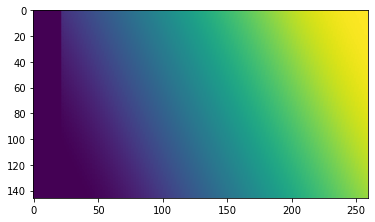

In [26]:
test = np.zeros(instance_corr.shape)
counter = 0
for s in stack:
    test[tuple(s)] = counter
    counter+=1
plt.imshow(test)

In [4]:
vec = (dest_inds-start_inds)/np.linalg.norm(dest_inds-start_inds)

In [7]:
shifts = get_half_donut(3,5,vec, 1.5)

In [11]:
shifts = np.asarray(shifts)

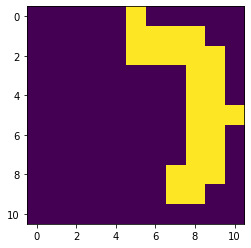

In [10]:
arr = np.zeros((11,11))
for s in shifts:
    arr[s[0]+5, s[1]+5] = 1
plt.imshow(arr)